### **Imports**

In [ ]:
# OS imports
from os.path import join, realpath, dirname, exists, abspath, isfile, isdir, basename
from os import mkdir, name as os_name, getcwd, environ, pathsep, rename, listdir, remove

# Mediapipe imports
from mediapipe.python.solutions import drawing_utils as du 
from mediapipe.python.solutions import hands
from google.protobuf.json_format import MessageToDict

# Tensorflow & Keras imports
import tensorflow as tf
from tensorflow.python.keras.utils.all_utils import to_categorical
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras.backend import set_session
from tensorflow.python.keras import optimizers
from tensorflow.python.keras import losses, metrics

# Data handeling/visualization imports
import cv2
from cv2 import imread, imshow, imwrite, flip, cvtColor, COLOR_BGR2RGB
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
from tabulate import tabulate

# General data handeling imports
from numpy import array, zeros, concatenate, save, load, argmax, expand_dims, append
import numpy as np
from uuid import uuid1

### **Definitions**

In [ ]:
# Options & Settings 💾
MODEL_VERSION = '1'
MODEL_ARCH_ID = 'conv1'
MODEL_DATA_SET = 'aTOf'
MODEL_NORMFUNC = 'n2'
MODEL_EXTRACTION_TYPE = 'absolute'
MODEL_DATA_PIPELINE = f'{MODEL_EXTRACTION_TYPE}{MODEL_NORMFUNC}'

MODEL_NAME = f'v{MODEL_VERSION}_{MODEL_ARCH_ID}_data-{MODEL_DATA_SET}_pipeline-{MODEL_DATA_PIPELINE}'

MP_MODEL_COMPLEXITY = 0
MP_DETECTION_CONFIDENCE = 0.75
MP_TRACKING_CONFIDENCE = 0.75
MP_NUM_HANDS = 1

SIGNS = [
  'a', 'b', 'c', 'd', 'e', 'f', # 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'
]

ALL_SIGNS = SIGNS.copy()
ALL_SIGNS.insert(0, 'none')
CLASS_COUNT = len(ALL_SIGNS)

# Constants 🚧
HAND_LANDMARK_COUNT = 21 # https://mediapipe.dev/images/mobile/hand_landmarks.png
HAND_POINT_COUNT = 3 # (x, y, z)
HAND_LANDMARK_POINTS = HAND_LANDMARK_COUNT * HAND_POINT_COUNT # (x, y, z)

# Paths 📁
ROOT_DIR = getcwd()
MODELS_DIR = join(ROOT_DIR, 'models')
MODEL_DIR = join(MODELS_DIR, MODEL_NAME)
MP_DIR = join(ROOT_DIR, 'mediapipe')
MP_MODEL_PATH = join(MP_DIR, 'models', 'hand_landmarker.task')
LOG_DIR = join(MODEL_DIR, 'logs')
SAVED_MODEL_PATH = join(MODEL_DIR, 'signs.h5')
EXPORTED_MODEL_DIR = join(MODEL_DIR)
DATA_DIR = join(ROOT_DIR, 'data')
IMAGES_DIR = join(ROOT_DIR, 'images')
COLLECTED_IMAGES_DIR = join(IMAGES_DIR, 'collected')
ACCEPTED_IMAGES_DIR = join(IMAGES_DIR, 'accepted')
REJECTED_IMAGES_DIR = join(IMAGES_DIR, 'rejected')

# Global Utils 📐
def create_dir(dir_path: str, notify: bool = True):
  if not exists(dir_path):
    mkdir(dir_path)
  else:
    if notify: print(f'{dir_path} already exists!')

def dir_exists(dir_path: str) -> bool:
  return exists(dir_path) and isdir(dir_path)

EMPTY_KEYPOINTS = zeros((HAND_LANDMARK_COUNT, 3))

### **Mediapipe Utilities**

In [ ]:
from typing import NamedTuple, Tuple
from numpy import ndarray

def draw_landmarks(image, results):
  if not results.multi_hand_landmarks: return image
  
  hand_landmarks = results.multi_hand_landmarks
  
  for point in hand_landmarks:
    du.draw_landmarks(
      image, point, hands.HAND_CONNECTIONS, 
      du.DrawingSpec(color=(119, 252, 3), thickness=1, circle_radius=2), 
      du.DrawingSpec(color=(119, 252, 3), thickness=1, circle_radius=2)
    )
    
def draw_img_landmarks(image, hand_landmarks):
  for point in hand_landmarks:
    du.draw_landmarks(
      image, point, hands.HAND_CONNECTIONS, 
      du.DrawingSpec(color=(224,0,0), thickness=32, circle_radius=5), # points
      du.DrawingSpec(color=(0,0,224), thickness=32, circle_radius=5) # edges
    )

def mediapipe_detection(image, hands: hands.Hands):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # COLOR CONVERSION BGR 2 RGB
  image.flags.writeable = False                   # Image is no longer writeable
  results = hands.process(image)                  # Make prediction
  image.flags.writeable = True                    # Image is now writeable
  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # COLOR COVERSION RGB 2 BGR
  return image, results

def get_handedness(results: NamedTuple) -> str:
  return MessageToDict(results.multi_handedness[0])['classification'][0]['label']

def is_right_hand(results: NamedTuple) -> bool:
  return get_handedness(results) == 'Right'

def extract_keypoints(results: NamedTuple) -> ndarray:
  if not results.multi_hand_landmarks:
    return EMPTY_KEYPOINTS
  landmarks = MessageToDict(results.multi_hand_landmarks[0])['landmark']

  res = []
  for landmark in landmarks:
    x = landmark['x']
    y = landmark['y']
    z = landmark['z']
    res.append([ x, y, z ])

  return array(res)

def extract_absolute_keypoints(results: NamedTuple) -> ndarray:
  if not results.multi_hand_landmarks:
    return EMPTY_KEYPOINTS
  landmarks = MessageToDict(results.multi_hand_world_landmarks[0])['landmark']
  # landmarks = MessageToDict(results.multi_hand_landmarks[0])['landmark']

  res = []
  for landmark in landmarks:
    x = landmark['x']
    y = landmark['y']
    z = landmark['z']
    res.append([ x, y, z ])

  return array(res)


def normalize_landmarks(arr: ndarray):
  """
  Transforms array of absolute positions into an array of normalized position within range [-1, 1]

  @param `landmarks` an array of landmark positions of shape (21, 3)
  @returns transformned NDArray of floats with shape (21, 3)
  """
  # Compute the minimum and maximum values separately for each dimension
  min_x, max_x = np.min(arr[:, 0]), np.max(arr[:, 0])
  min_y, max_y = np.min(arr[:, 1]), np.max(arr[:, 1])
  min_z, max_z = np.min(arr[:, 2]), np.max(arr[:, 2])

  # Normalize each dimension separately
  arr[:, 0] = (arr[:, 0] - min_x) / (max_x - min_x)
  arr[:, 1] = (arr[:, 1] - min_y) / (max_y - min_y)
  arr[:, 2] = (arr[:, 2] - min_z) / (max_z - min_z)

  return arr

def normalize_landmarks2(landmarks: ndarray):
  # Compute the centroid
  centroid = np.mean(landmarks, axis=0)

  # Translate the points to the centroid
  translated_landmarks = landmarks - centroid

  # Compute the scaling factor
  scale_factor = np.max(np.linalg.norm(translated_landmarks, axis=1))

  if scale_factor == 0:
    return translated_landmarks

  # Normalize the points
  normalized_landmarks = translated_landmarks / scale_factor

  return normalized_landmarks

def normalize_landmarks3(landmarks: ndarray) -> ndarray:
  # Calculate the minimum and maximum values along each axis
  min_values = np.min(landmarks, axis=0)
  max_values = np.max(landmarks, axis=0)

  # Compute the bounding box dimensions
  bounding_box_dimensions = max_values - min_values

  # Compute the scaling factor as the maximum dimension of the bounding box
  scaling_factor = np.max(bounding_box_dimensions)

  # Translate the points so that the minimum values along each axis are at the origin
  translated_landmarks = landmarks - min_values

  # Scale the translated points to fit inside the 1x1x1 box
  scaled_landmarks = translated_landmarks / scaling_factor

  # Translate the scaled points so that their origin is at (0, 0, 0)
  min_values_scaled = np.min(scaled_landmarks, axis=0)
  normalized_landmarks = scaled_landmarks - min_values_scaled

  return normalized_landmarks

def print_landmark_values(data: ndarray):
  print(tabulate(data, headers=["x", "y", "z"], floatfmt=".4f", stralign='right', numalign='decimal'))

### **Image Collection & Preprocessing**

In [ ]:
#Camera Check

camera_index = 0
while True:
    cap = cv2.VideoCapture(camera_index, cv2.CAP_DSHOW)
    if not cap.read()[0]:
        break
    else:
        print(f"Camera index: {camera_index} - OK")
    cap.release()
    camera_index += 1

In [ ]:
# Live Image collection

cap = cv2.VideoCapture(0)

selected_sign_index = 0
selected_sign = SIGNS[selected_sign_index]
selected_sign_amount = len(listdir(join(DATA_DIR, selected_sign)))

def select_next_sign():
  global selected_sign, selected_sign_index, selected_sign_amount
  if selected_sign_index < len(SIGNS) - 1:
    selected_sign_index += 1
    selected_sign = SIGNS[selected_sign_index]
    selected_sign_amount = len(listdir(join(DATA_DIR, selected_sign)))

def select_prev_sign():
  global selected_sign, selected_sign_index, selected_sign_amount
  if selected_sign_index > 0:
    selected_sign_index -= 1
    selected_sign = SIGNS[selected_sign_index]
    selected_sign_amount = len(listdir(join(DATA_DIR, selected_sign)))

def capture(results, image):
  global selected_sign, selected_sign_amount
  if not results.multi_hand_landmarks:
    print('no hand available')
    return
  if not is_right_hand(results):
    print('must use right hand')
    return

  keypoints = extract_absolute_keypoints(results) # absolute
  data = normalize_landmarks2(keypoints) # n2

  generated_name = f'{selected_sign}_{selected_sign_amount}.{uuid1()}'
  data_path = join(DATA_DIR, selected_sign, generated_name)
  img_path = join(COLLECTED_IMAGES_DIR, selected_sign, generated_name) + '.jpeg'
  save(data_path, data)
  imwrite(img_path, image)
  print(f'saved {generated_name}')
  selected_sign_amount = len(listdir(join(DATA_DIR, selected_sign)))

with hands.Hands(
  model_complexity=MP_MODEL_COMPLEXITY,
  min_detection_confidence=MP_DETECTION_CONFIDENCE,
  min_tracking_confidence=MP_TRACKING_CONFIDENCE,
  max_num_hands=MP_NUM_HANDS
) as mp_hands:
  while cap.isOpened():
    
    success, image = cap.read()
    raw_image = image
    image = flip(image, 1)
    
    if not success:
      print("Ignoring empty camera frame.")
      continue

    image, results = mediapipe_detection(image, mp_hands)
    draw_landmarks(image, results)
    image = cv2.putText(
      image, f'{selected_sign} | {selected_sign_amount}',
      (32, 32), cv2.FONT_HERSHEY_SIMPLEX, 1, (119, 252, 3), 2, cv2.LINE_AA
    )
      
    # Flip the image horizontally for a selfie-view display.
    imshow('signs', image)
    
    key = cv2.waitKeyEx(1)

    if key == 32: # space bar
      capture(results, raw_image)

    if key == 2555904: # right key
      select_next_sign()

    if key == 2424832: # left key
      select_prev_sign()
      
    if key == 27:
      break
  
cap.release()
cv2.destroyAllWindows()

In [ ]:
# Image selection TODO!

cap = cv2.VideoCapture(0)

image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']

def get_image_paths(directory):
  image_paths = {}

  for subdir in listdir(directory):
    subdir_path = join(directory, subdir)
    if isdir(subdir_path):
      images = []
      for filename in listdir(subdir_path):
        if any(filename.endswith(ext) for ext in image_extensions):
          images.append(join(subdir_path, filename))
      image_paths[subdir] = images

  return image_paths

show_landmarks = True
selected_sign = SIGNS[0]
selected_img_index = 0

images_paths = get_image_paths(COLLECTED_IMAGES_DIR)

def create_black_image(width, height):
  return zeros((height, width, 3), dtype=np.uint8)

def move_files(img_id, img):
  pass

def accept(img):
  pass


def reject(img):
  pass


def move_right():
  pass

def move_left():
  pass

def move_up():
  pass

def move_down():
  pass

with hands.Hands(
  model_complexity=MP_MODEL_COMPLEXITY,
  min_detection_confidence=MP_DETECTION_CONFIDENCE,
  min_tracking_confidence=MP_TRACKING_CONFIDENCE,
  max_num_hands=MP_NUM_HANDS
) as mp_hands:
  while True:

    key = cv2.waitKey(0)

    can_do_stuff = len(images_paths[selected_sign]) > 0

    image = create_black_image(640, 480)

    if can_do_stuff:
      img_path = images_paths[selected_sign][selected_img_index]
      image = cv2.imread(img_path)
    else:
      # add some text to blck screen
      pass

    imshow('signs', image)

    if key == 101 and can_do_stuff: # e "accept"
      accept(image)

    if key == 113 and can_do_stuff: # q "reject"
      reject(image)

    if key == 2555904 and can_do_stuff: # right key
      move_right()

    if key == 2424832 and can_do_stuff: # left key
      move_left()

    if key == 2490368: # up arrow key
      move_up()

    if key == 2621440: # down arrow key
      move_down()
      
    if key == 27:
      break

cv2.destroyAllWindows()

*generate empty folders*

In [ ]:
directories = [
  COLLECTED_IMAGES_DIR,
  ACCEPTED_IMAGES_DIR,
  REJECTED_IMAGES_DIR,
  DATA_DIR
]

for directory in directories:
  for s in SIGNS:
    create_dir(join(directory, s), False)


### **Models**

In [ ]:
def conv1():
  model = Sequential()

  model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(21, 3)))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(CLASS_COUNT, activation='softmax'))

  return model

### **Training**

##### *Model Selection*

In [ ]:
def get_model() -> Sequential:
  return conv1()

##### *Loading & Partitioning data*

In [ ]:
def get_collection_count():
  data_amounts = []
  for sign in SIGNS:
    data_directory = join(DATA_DIR, sign)
    data_amounts.append(len(listdir(join(DATA_DIR, data_directory))))

      
  return min(data_amounts)

COLLECTION_COUNT = get_collection_count()
print(f'currently using {COLLECTION_COUNT} data points')

# Load Training Data
label_map = { label: num for num, label in enumerate(ALL_SIGNS) }
sequences, labels = [zeros((COLLECTION_COUNT, 21, 3)), [ 0 for _ in range(COLLECTION_COUNT) ]]


for sign in SIGNS:
  sign_data_dir = join(DATA_DIR, sign)
  for data_file_name in listdir(sign_data_dir)[:COLLECTION_COUNT]:
    data_path = join(sign_data_dir, data_file_name)
    res = load(data_path)
    expanded_res = expand_dims(res, axis=0)
    sequences = concatenate((sequences, expanded_res), axis=0)
    labels.append(label_map[sign])

x = array(sequences)
y = to_categorical(labels).astype(int)

# Testing!
x_shape_expected = (CLASS_COUNT * COLLECTION_COUNT, HAND_LANDMARK_COUNT, HAND_POINT_COUNT)
x_shape_result = x.shape
y_shape_expected = (CLASS_COUNT * COLLECTION_COUNT, CLASS_COUNT)
y_shape_result = y.shape
if x_shape_result != x_shape_expected:
  raise Exception(f'ERROR: expected sequence shape `{x_shape_expected}` != from gotten `{x_shape_result}`')
if y_shape_result != y_shape_expected:
  raise Exception(f'ERROR: expected labels shape `{y_shape_expected}` != from gotten `{y_shape_result}`')

# partitioning train, test, validation data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1 * 1.0)            # 10% test data (1.0 * 0.20 = 0.1 => 10%)
x_train, x_val,  y_train, y_val  = train_test_split(x_train, y_train, test_size=0.1/0.9)  # 10% val  data (0.9 * 0.11 = 0.1 => 10%)

##### *Training*

In [ ]:
class EarlyStoppingByLoss(tf.keras.callbacks.Callback):
  def __init__(self, target_loss):
    super(EarlyStoppingByLoss, self).__init__()
    self.target_loss = target_loss

  def on_epoch_end(self, epoch, logs=None):
    current_loss = logs.get('loss')
    if current_loss is not None and current_loss <= self.target_loss:
      print(f"\nReached target loss {self.target_loss}, stopping training.")
      self.model.stop_training = True

In [ ]:
mkdir(MODEL_DIR)
mkdir(LOG_DIR)

tb_callback = TensorBoard(log_dir=LOG_DIR)
early_stopping_by_loss = EarlyStoppingByLoss(target_loss=0.1)
terminal_log_dir = LOG_DIR.replace('\\', '/')

model = get_model()

model.compile(
  optimizer=optimizers.adam_v2.Adam(learning_rate=0.000025),
  loss=losses.CategoricalCrossentropy(),
  metrics=[metrics.CategoricalCrossentropy(), metrics.CategoricalAccuracy()]
)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(f'[RUN]: tensorboard --logdir={terminal_log_dir}')

model.fit(
  x_train, y_train, validation_data=(x_val, y_val),
  epochs=10000, batch_size=10,
  use_multiprocessing=True, workers=4,
  callbacks=[tb_callback],
)

In [ ]:
model.save(SAVED_MODEL_PATH)
del model

### **Testing**

##### *Model*

In [ ]:
# LOAD MODEL 💾
model = get_model()
model.load_weights(SAVED_MODEL_PATH)
print(model.summary())

In [ ]:
# POST-TRAINING PREDICIONS ⚡
res = model.predict(x_test)

y_real = []
y_pred = []

for i in range(len(res)):
  y_real.append(argmax(y_test[i]))
  y_pred.append(argmax(res[i]))

y_real = array(y_real)
y_pred = array(y_pred)

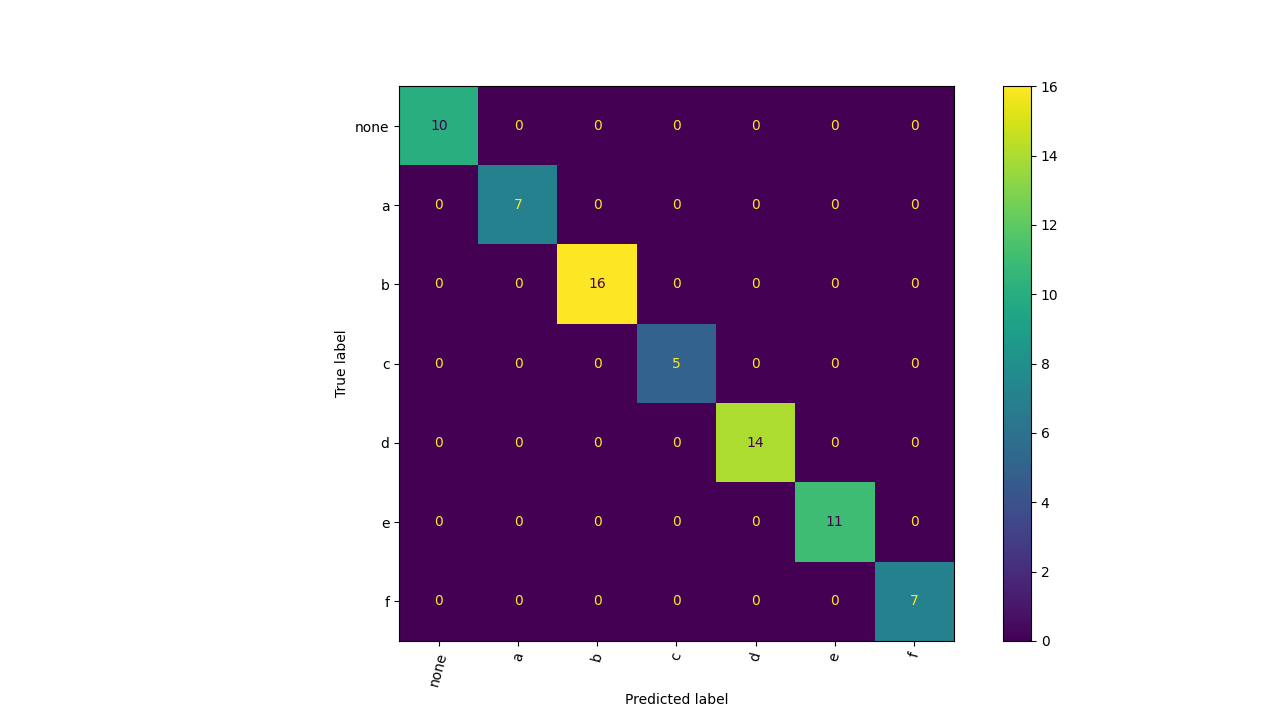

In [80]:
# GENERATE CONFUSION MATRIX 😵
cm = confusion_matrix(y_real, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ALL_SIGNS)
disp.plot(xticks_rotation=75)
disp.figure_.set_size_inches(12.8, 7.2)
disp.figure_.set_dpi(150)
plt.show()

In [ ]:
model = get_model()
model.load_weights(SAVED_MODEL_PATH)

predicted_sign = 'none'
threshold = 0.5

cap = cv2.VideoCapture(0)
with hands.Hands(
  model_complexity=MP_MODEL_COMPLEXITY,
  min_detection_confidence=MP_DETECTION_CONFIDENCE,
  min_tracking_confidence=MP_TRACKING_CONFIDENCE,
  max_num_hands=MP_NUM_HANDS
) as mp_hands:
  while cap.isOpened():
    
    success, image = cap.read()
    image = flip(image, 1)
    
    if not success:
      print("Ignoring empty camera frame.")
      continue

    image, results = mediapipe_detection(image, mp_hands)
    draw_landmarks(image, results)
    
    keypoints = extract_absolute_keypoints(results)
    data = normalize_landmarks2(keypoints)

    prediction = model.predict(expand_dims(data, axis=0))[0]
    predicted_class_index = argmax(prediction)

    print(ALL_SIGNS[predicted_class_index], prediction[predicted_class_index])


      
    # Flip the image horizontally for a selfie-view display.
    imshow(MODEL_NAME, image)
    
    key = cv2.waitKeyEx(1)
    if key == 27:
      break
  
cap.release()
cv2.destroyAllWindows()

##### *Data*

In [ ]:
%matplotlib widget

data_path = join(DATA_DIR, 'a', 'a_60.2199bfd2-ec50-11ed-a7f5-1c872c4889a8.npy')

# points = load(data_path)
points = normalize_landmarks3(load(data_path))

x = points[:, 0]
y = points[:, 1]
z = points[:, 2]

# Set up the 3D scatter plot
fig = plt.figure(figsize=(13, 13))
ax = fig.add_subplot(111, projection='3d')

# https://developers.google.com/static/mediapipe/images/solutions/hand-landmarks.png
pairs_to_connect = [
  (0, 1), (1, 2), (2, 3), (3, 4),
  (0, 5), (5, 6), (6, 7), (7, 8),
  (0, 17), (17, 18), (18, 19), (19, 20),
  (5, 9), (9, 13), (13, 17),
  (9, 10), (10, 11), (11, 12),
  (13, 14), (14, 15), (15, 16),
]

for pair in pairs_to_connect:
  idx1, idx2 = pair
  ax.plot(x[[idx1, idx2]], y[[idx1, idx2]], z[[idx1, idx2]], linestyle='-', linewidth=1)

ax.scatter(x, y, z, s=100)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Set the elevation and azimuth angles (in degrees)
elevation_angle = -106
azimuth_angle = -75
ax.view_init(elevation_angle, azimuth_angle)

# Show the plot
plt.show()

In [ ]:
def average_difference(set1: np.ndarray, set2: np.ndarray) -> np.ndarray:
  if set1.shape != set2.shape:
    raise ValueError("Input sets should have the same shape.")
    
  # Calculate the absolute differences between corresponding points
  absolute_differences = np.abs(set1 - set2)
  
  # Calculate the sum of absolute differences for each axis
  sum_differences = np.sum(absolute_differences, axis=0)
  
  # Calculate the sum of the values in set1 for each axis
  sum_set1 = np.sum(set1, axis=0)
  
  # Calculate the percentage difference for each axis
  percentage_difference = 100 * sum_differences / sum_set1
  
  return percentage_difference


data_path = join(DATA_DIR, 'a', 'test.npy')

dataRaw = load(data_path)
datan1 = normalize_landmarks2(dataRaw)
datan2 = normalize_landmarks3(dataRaw)


print(average_difference(datan1, datan2))

# headers = ["x", "y", "z"]
# print(tabulate(datan2, headers=headers, tablefmt="pretty", floatfmt=".4f", stralign='right', numalign='decimal'))